## Libraries



In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# foldername = '/home/mrsergazinov/python-git-workspace/gluformer/'
foldername = '/content/drive/My Drive/github/gluformer/'
assert foldername is not None, "[!] Enter the foldername."

# add path to .py code
import sys
sys.path.append(foldername)

Mounted at /content/drive


In [2]:
%%capture
!pip install pytorch-lightning==1.4.9
!pip install pytorch-forecasting
!pip install pandas --upgrade

In [59]:
import numpy as np
import pandas as pd
import os
import pickle
import seaborn as sns
import matplotlib.pylab as plt

import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

import tensorflow as tf 
import tensorboard as tb 
tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

## Preprocessing Data

In [4]:
path = foldername + 'gludata/data'
with open(path+"/test_data_pyforecast.pkl", 'rb') as f:
      test_data_raw = pickle.load(f)

In [5]:
def read_data(data):
    data_len = sum([len(data[i][1]) for i in range(len(data))])
    data_pd = pd.DataFrame(index = range(data_len),
                           columns = ["id", "segment", "timeidx", "CGM", 
                                      "dayofyear", "dayofmonth", "dayofweek", "hour", 
                                      "minute", "date"])
    start = 0
    for i in range(len(data)):
        block_len = len(data[i][1]) 
        data_pd["id"][start:(start+block_len)] = [data[i][0]] * block_len
        data_pd["segment"][start:(start+block_len)] = [str(i)] * block_len 
        data_pd["timeidx"][start:(start+block_len)] = range(block_len)
        data_pd["CGM"][start:(start+block_len)] = data[i][1].flatten() 
        data_pd["date"][start:(start+block_len)] = data[i][3]
        start += block_len
    
    # set format
    data_pd["timeidx"] = data_pd["timeidx"].astype("int")
    data_pd["CGM"] = data_pd["CGM"].astype("float")
    
    #extract time features
    data_pd["date"] = pd.to_datetime(data_pd["date"])
    data_pd["dayofyear"] = data_pd["date"].dt.dayofyear.astype("string").astype("category")
    data_pd["dayofmonth"] = data_pd["date"].dt.day.astype("string").astype("category")
    data_pd["dayofweek"] = data_pd["date"].dt.dayofweek.astype("string").astype("category")
    data_pd["hour"] = data_pd["date"].dt.hour.astype("string").astype("category")
    data_pd["minute"] = data_pd["date"].dt.minute.astype("string").astype("category")
    
    # add id and segment 
    data_pd["id"] = data_pd["id"].astype(str).astype("string").astype("category")
    data_pd["segment"] = data_pd["segment"].astype(str).astype("string").astype("category")
    
    # reset index
    data_pd = data_pd.reset_index()
    data_pd = data_pd.drop(columns=["index"])
    return data_pd

test_data_pd = read_data(test_data_raw)

In [73]:
test_data = TimeSeriesDataSet(
    test_data_pd,
    time_idx="timeidx",
    target="CGM",
    group_ids=["id", "segment"],
    max_encoder_length=180,
    max_prediction_length=12,
    static_categoricals=["id"],
    time_varying_known_categoricals= ["dayofyear", 
                                      "dayofmonth", 
                                      "dayofweek", 
                                      "hour",
                                      "minute"],
    time_varying_known_reals=["timeidx"],
    time_varying_unknown_reals = ["CGM"],
    target_normalizer=None,
    add_relative_time_idx=True,
    add_encoder_length=True,
)
test_dataloader = test_data.to_dataloader(train=False, batch_size=32, num_workers=0)

## Evaluating Model

In [65]:
tft = TemporalFusionTransformer.from_dataset(
    test_data,
    learning_rate=0.001,
    hidden_size=160,
    attention_head_size=4,
    dropout=0.1,
    hidden_continuous_size=160,
    output_size=7,  # 7 quantiles by default
    loss=QuantileLoss(),
    log_interval=10,  # uncomment for learning rate finder and otherwise, e.g. to 10 for logging every 10 batches
    reduce_on_plateau_patience=4,
)
tft_fitted = tft.load_from_checkpoint(foldername+'/logs-compare/saved_models/tft.ckpt')

In [66]:
# calcualte mean absolute error on validation set
UPPER = 402
LOWER = 38
SCALE_1 = 5
SCALE_2 = 2

HYPO_THR = 70
HYPER_THR = 180

actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions = tft_fitted.predict(test_dataloader)

actuals = (actuals + SCALE_1) / (SCALE_1 * SCALE_2) * (UPPER - LOWER) + LOWER
predictions = (predictions + SCALE_1) / (SCALE_1 * SCALE_2) * (UPPER - LOWER) + LOWER

# evaluate on full data set
ape_3 = ((actuals[:, :3] - predictions[:, :3]).abs() / actuals[:, :3].abs()).mean(axis=1).median()
ape_6 = ((actuals[:, :6] - predictions[:, :6]).abs() / actuals[:, :6].abs()).mean(axis=1).median()
ape_9 = ((actuals[:, :9] - predictions[:, :9]).abs() / actuals[:, :9].abs()).mean(axis=1).median()
ape_12 = ((actuals - predictions).abs() / actuals.abs()).mean(axis=1).median()

rmse_3 = ((actuals[:, :3] - predictions[:, :3]) ** 2).mean(axis=1).sqrt().median()
rmse_6 = ((actuals[:, :6] - predictions[:, :6]) ** 2).mean(axis=1).sqrt().median()
rmse_9 = ((actuals[:, :9] - predictions[:, :9]) ** 2).mean(axis=1).sqrt().median()
rmse_12 = ((actuals - predictions) ** 2).mean(axis=1).sqrt().median()

print("RMSE for 15 mins: {0:.7f}, for 30 mins: {1:.7f}, for 45 mins: : {2:.7f}, for 60 mins: {3:.7f}".format(
    np.median(np.array(rmse_3)), 
    np.median(np.array(rmse_6)),
    np.median(np.array(rmse_9)),
    np.median(np.array(rmse_12))))

print("APE for 15 mins: {0:.7f}, for 30 mins: {1:.7f}, for 45 mins: : {2:.7f}, for 60 mins: {3:.7f}".format(
    np.median(np.array(ape_3)), 
    np.median(np.array(ape_6)),
    np.median(np.array(ape_9)),
    np.median(np.array(ape_12))))

RMSE for 15 mins: 5.1909100, for 30 mins: 8.6636738, for 45 mins: : 11.7346232, for 60 mins: 14.7841051
APE for 15 mins: 0.0290729, for 30 mins: 0.0468084, for 45 mins: : 0.0630646, for 60 mins: 0.0777355


In [18]:
# evaluate on the hypo
select = (actuals <= HYPO_THR).any(axis=1)
ape_3 = ((actuals[select, :3] - predictions[select, :3]).abs() / actuals[select, :3].abs()).mean(axis=1).median()
ape_6 = ((actuals[select, :6] - predictions[select, :6]).abs() / actuals[select, :6].abs()).mean(axis=1).median()
ape_9 = ((actuals[select, :9] - predictions[select, :9]).abs() / actuals[select, :9].abs()).mean(axis=1).median()
ape_12 = ((actuals[select, :] - predictions[select, :]).abs() / actuals[select, :].abs()).mean(axis=1).median()

rmse_3 = ((actuals[select, :3] - predictions[select, :3]) ** 2).mean(axis=1).sqrt().median()
rmse_6 = ((actuals[select, :6] - predictions[select, :6]) ** 2).mean(axis=1).sqrt().median()
rmse_9 = ((actuals[select, :9] - predictions[select, :9]) ** 2).mean(axis=1).sqrt().median()
rmse_12 = ((actuals[select, :] - predictions[select, :]) ** 2).mean(axis=1).sqrt().median()

print("RMSE for 15 mins: {0:.7f}, for 30 mins: {1:.7f}, for 45 mins: : {2:.7f}, for 60 mins: {3:.7f}".format(
    np.median(np.array(rmse_3)), 
    np.median(np.array(rmse_6)),
    np.median(np.array(rmse_9)),
    np.median(np.array(rmse_12))))

print("APE for 15 mins: {0:.7f}, for 30 mins: {1:.7f}, for 45 mins: : {2:.7f}, for 60 mins: {3:.7f}".format(
    np.median(np.array(ape_3)), 
    np.median(np.array(ape_6)),
    np.median(np.array(ape_9)),
    np.median(np.array(ape_12))))

RMSE for 15 mins: 5.6613047, for 30 mins: 8.3841024, for 45 mins: : 11.0291077, for 60 mins: 13.5453957
APE for 15 mins: 0.0802313, for 30 mins: 0.1201442, for 45 mins: : 0.1590264, for 60 mins: 0.1945413


In [19]:
# evaluate on the hyper
select = (actuals >= HYPER_THR).any(axis=1)
ape_3 = ((actuals[select, :3] - predictions[select, :3]).abs() / actuals[select, :3].abs()).mean(axis=1).median()
ape_6 = ((actuals[select, :6] - predictions[select, :6]).abs() / actuals[select, :6].abs()).mean(axis=1).median()
ape_9 = ((actuals[select, :9] - predictions[select, :9]).abs() / actuals[select, :9].abs()).mean(axis=1).median()
ape_12 = ((actuals[select, :] - predictions[select, :]).abs() / actuals[select, :].abs()).mean(axis=1).median()

rmse_3 = ((actuals[select, :3] - predictions[select, :3]) ** 2).mean(axis=1).sqrt().median()
rmse_6 = ((actuals[select, :6] - predictions[select, :6]) ** 2).mean(axis=1).sqrt().median()
rmse_9 = ((actuals[select, :9] - predictions[select, :9]) ** 2).mean(axis=1).sqrt().median()
rmse_12 = ((actuals[select, :] - predictions[select, :]) ** 2).mean(axis=1).sqrt().median()

print("RMSE for 15 mins: {0:.7f}, for 30 mins: {1:.7f}, for 45 mins: : {2:.7f}, for 60 mins: {3:.7f}".format(
    np.median(np.array(rmse_3)), 
    np.median(np.array(rmse_6)),
    np.median(np.array(rmse_9)),
    np.median(np.array(rmse_12))))

print("APE for 15 mins: {0:.7f}, for 30 mins: {1:.7f}, for 45 mins: : {2:.7f}, for 60 mins: {3:.7f}".format(
    np.median(np.array(ape_3)), 
    np.median(np.array(ape_6)),
    np.median(np.array(ape_9)),
    np.median(np.array(ape_12))))

RMSE for 15 mins: 6.3314895, for 30 mins: 10.7522980, for 45 mins: : 15.0206407, for 60 mins: 19.1718049
APE for 15 mins: 0.0246752, for 30 mins: 0.0399654, for 45 mins: : 0.0543034, for 60 mins: 0.0685013


In [24]:
# evaluate on the hypo and hyper
select = ((actuals <= HYPO_THR).any(axis=1) |  (actuals >= HYPER_THR).any(axis=1))
ape_3 = ((actuals[select, :3] - predictions[select, :3]).abs() / actuals[select, :3].abs()).mean(axis=1).median()
ape_6 = ((actuals[select, :6] - predictions[select, :6]).abs() / actuals[select, :6].abs()).mean(axis=1).median()
ape_9 = ((actuals[select, :9] - predictions[select, :9]).abs() / actuals[select, :9].abs()).mean(axis=1).median()
ape_12 = ((actuals[select, :] - predictions[select, :]).abs() / actuals[select, :].abs()).mean(axis=1).median()

rmse_3 = ((actuals[select, :3] - predictions[select, :3]) ** 2).mean(axis=1).sqrt().median()
rmse_6 = ((actuals[select, :6] - predictions[select, :6]) ** 2).mean(axis=1).sqrt().median()
rmse_9 = ((actuals[select, :9] - predictions[select, :9]) ** 2).mean(axis=1).sqrt().median()
rmse_12 = ((actuals[select, :] - predictions[select, :]) ** 2).mean(axis=1).sqrt().median()

print("RMSE for 15 mins: {0:.7f}, for 30 mins: {1:.7f}, for 45 mins: : {2:.7f}, for 60 mins: {3:.7f}".format(
    np.median(np.array(rmse_3)), 
    np.median(np.array(rmse_6)),
    np.median(np.array(rmse_9)),
    np.median(np.array(rmse_12))))

print("APE for 15 mins: {0:.7f}, for 30 mins: {1:.7f}, for 45 mins: : {2:.7f}, for 60 mins: {3:.7f}".format(
    np.median(np.array(ape_3)), 
    np.median(np.array(ape_6)),
    np.median(np.array(ape_9)),
    np.median(np.array(ape_12))))

RMSE for 15 mins: 6.2197409, for 30 mins: 10.1847716, for 45 mins: : 14.2081729, for 60 mins: 18.2111075
APE for 15 mins: 0.0288610, for 30 mins: 0.0464355, for 45 mins: : 0.0631509, for 60 mins: 0.0787592


## Plot

In [74]:
actuals = torch.cat([y[0] for x, y in iter(test_dataloader)])
predictions, x = tft_fitted.predict(test_dataloader, mode = "quantiles", return_x = True)

In [69]:
actuals = (actuals + SCALE_1) / (SCALE_1 * SCALE_2) * (UPPER - LOWER) + LOWER
predictions = (predictions + SCALE_1) / (SCALE_1 * SCALE_2) * (UPPER - LOWER) + LOWER
x = (x['encoder_target'] + SCALE_1) / (SCALE_1 * SCALE_2) * (UPPER - LOWER) + LOWER

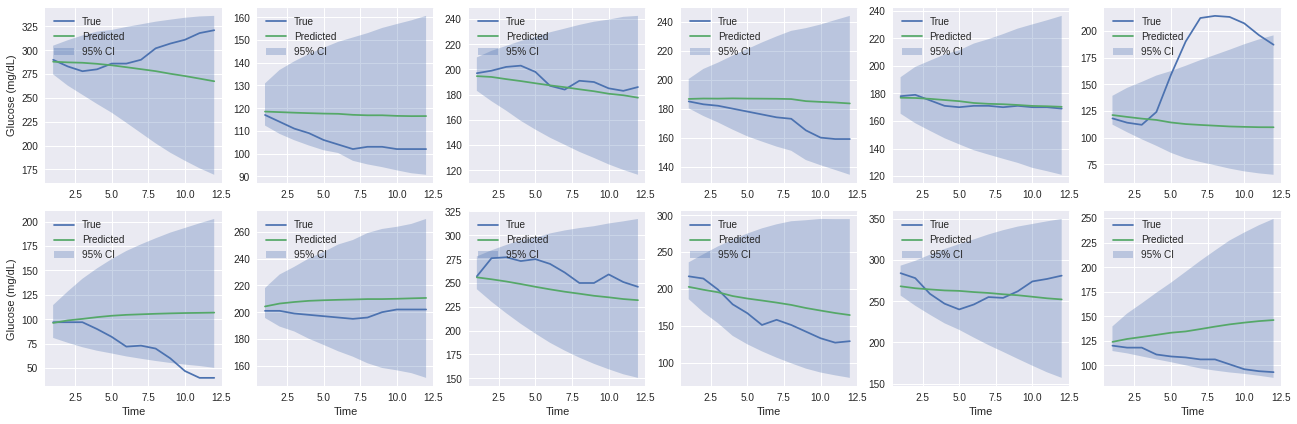

In [72]:
def subplt(fig, index, x, y, yhat):
  ax = fig.add_subplot(2, 6, index)
  quants = yhat[:, [0, 6]]
  mean = yhat[:, 3]
  ax.plot(range(1,13), y, label = "True")
  ax.plot(range(1,13), mean, label = "Predicted")
  # ax.plot(range(-180, 0, 1), x)
  if index > 6:
    ax.set(xlabel="Time")
  if index == 1 or index == 7:
    ax.set(ylabel="Glucose (mg/dL)")
  ax.fill_between(range(1,13), quants[:, 0], quants[:, 1], alpha=0.3, label = "95% CI")
  ax.legend(loc='upper left')

plt.style.use("seaborn")
fig = plt.figure()
fig.set_size_inches(18, 6)
fig.subplots_adjust(hspace=0.2, wspace=0.4) 

sample = [1000, 3000, 4105, 
          5000, 6000, 7000, 
          7500, 9000, 10000,
          11000, 12000, 12500]
for i in range(1, 13):
  subplt(fig, i, x[sample[i-1]], actuals[sample[i-1]], predictions[sample[i-1]])

plt.tight_layout()
plt.savefig(foldername + 'confidence.pdf', dpi=300)